# Import

In [1]:
from joblib import Parallel, delayed
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
from os import path
import pandas as pd 
import os
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
import datetime
import math
import time
import pickle
import random
from scipy.spatial import cKDTree
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sys
from sklearn.metrics import r2_score as r2
#from rdkit import Chem
from sklearn.decomposition import PCA
import rishi_utils as ru

import importlib
import efrc_ml_production as ml
importlib.reload(ml)
importlib.reload(ru)
from skopt import gp_minimize

from multiprocessing import Pool

In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.backend import manual_variable_initialization
manual_variable_initialization(True)
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import LeaveOneOut,KFold

In [3]:
import shap

In [4]:
from sklearn.preprocessing import RobustScaler

In [5]:
from sklearn.metrics import r2_score

In [6]:
import parityPlot as pp

In [458]:
df = ru.pd_load('/data/rgur/efrc/polymer_membrane/fingerprint.csv')

In [459]:
df.head()

,_Polymer Intitials,_Polymer name,_SMILES,_FFV,_P(CH4),_P(N2),_P(O2),_P(CO2),_P(H2),_P(He),...,mfp_MQNs36,mfp_MQNs37,mfp_MQNs38,mfp_MQNs39,mfp_MQNs40,mfp_MQNs41,mfp_MQNs42,mfp_NumAliphaticRings,mfp_NumAromaticRings,mfp_tpsa
0,PC,bisphenol-A polycarbonate,[*]Oc2ccc(C(C)(C)c1ccc(OC([*])=O)cc1)cc2,0.164,0.36,0.38,1.6,6.8,13.3,13.0,...,0.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060606,0.269167
1,PSF,bisphenol-A polysulfone,CC(c1ccc(cc1)O[*])(c1ccc(cc1)Oc1ccc(cc1)S(=O)(...,0.156,0.25,0.25,1.4,5.6,14.0,13.0,...,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074074,0.243519
2,TMPC,tetramethyl bisphenol-A polycarbonate,[*]Oc1c(C)cc(cc1C)C(c1cc(C)c(c(c1)C)OC(=O)[*])...,0.180,0.89,1.10,5.6,18.6,NaN,46.0,...,0.044444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044444,0.197389
3,TMPSF,tetramethyl bisphenol-A polysulfone,[*]Oc4c(C)cc(C(C)(C)c3cc(C)c(Oc2ccc(S(=O)(=O)c...,0.171,0.95,1.06,5.6,21,32.0,41.0,...,0.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060606,0.199242
4,TCPC,tetrachloro bisphenol-A polycarbonate,[*]Oc2c(Cl)cc(C(C)(C)c1cc(Cl)c(OC([*])=O)c(Cl)...,0.179,0.22,0.36,2.3,6.7,NaN,27.4,...,0.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060606,0.269167


In [460]:
len(df)

133

In [461]:
df_path = '/data/rgur/efrc/polymer_membrane/fingerprint.csv'
other_params = {
    'col_Y':['_FFV'],
    'scorer': ml.get_rmse,
    'experiment_dir':'/data/rgur/efrc/polymer_membrane/nn_test',
    'hp_n_folds': 5,
    'N_CALLS': 20
}
nn_params = {
    'bs': [2,40],
    'n_layers': 3,
    'n_units': 200,
    'patience': 15
}

In [462]:
df=df.dropna(subset=other_params['col_Y'],axis=0)

In [463]:
pg_cols = [col for col in df.columns.tolist() if col[0] != '_']
len(pg_cols)

251

# Split and train

In [544]:
#transformer = RobustScaler()
train = df.sample(frac=.5)
#train[pg_cols] = transformer.fit_transform(train[pg_cols].to_numpy())

val= df.drop(train.index).sample(frac=.5)
#val[pg_cols] = transformer.transform(val[pg_cols].to_numpy())
test= df.drop(val.index).drop(train.index)
len(train), len(val), len(test)

(66, 33, 33)

In [545]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = train[pg_cols], train['_FFV'], val[pg_cols], val['_FFV'], \
                                                    val[pg_cols], val['_FFV']

In [554]:
def build_model(n_features, lr, h_units, ACTIVATION='relu'):
    #x = tf.placeholder('float', shape = [None, n_features])
    hidden_ls = [layers.Dense(n, activation='relu') for n in h_units[1:]]
    model = keras.Sequential(
        [layers.Dense(h_units[0], activation='relu', input_shape=[n_features])] + #default is 100
        [val for pair in zip([layers.Dropout(.1)]*len(hidden_ls),hidden_ls) for val in pair] + 
        #hidden_ls + [layers.Dropout(.1)]
        [layers.Dense(1, activation='linear')] #default activation is None
    )

    opt = keras.optimizers.Adam(learning_rate=lr) #default is .001

    model.compile(loss='mae',
        optimizer=opt,
        metrics=['mae', 'mse'])
    return model 

In [562]:
MODEL = build_model(len(pg_cols), .001, [400, 15, 10])

In [563]:
os.chdir('/data/rgur/efrc/polymer_membrane/nn_test/')

In [564]:
patience = 50
BS = 50
lr_patience = round(patience/5)

In [565]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
checkpoint_callbacks = keras.callbacks.ModelCheckpoint(filepath='%s.h5' %'checkpoint', 
                                                       monitor='val_loss',\
                                                      verbose=1, save_best_only=True, mode='auto')
lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=lr_patience, 
                                                verbose=0, mode='auto', min_delta=0.0001, cooldown=0,
                                                min_lr=.0005)

In [566]:
MODEL.fit(train_X, train_Y, batch_size=BS,epochs=1000, verbose=1, 
          callbacks=[checkpoint_callbacks, early_stop],
            validation_split=None, validation_data=(val_X,val_Y), shuffle=True, class_weight=None,
            sample_weight=None, initial_epoch=0, steps_per_epoch=None,
            validation_steps=None, validation_freq=1, max_queue_size=10, workers=1,
            use_multiprocessing=False
         )
MODEL.load_weights(filepath='%s.h5' %'checkpoint')

Epoch 1/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.0508 - mae: 1.0508 - mse: 1.8473
Epoch 00001: val_loss improved from inf to 0.73973, saving model to checkpoint.h5
2/2 [==============================] - 0s 92ms/step - loss: 0.9085 - mae: 0.9085 - mse: 1.4971 - val_loss: 0.7397 - val_mae: 0.7397 - val_mse: 0.7126
Epoch 2/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.4051 - mae: 0.4051 - mse: 0.3087
Epoch 00002: val_loss improved from 0.73973 to 0.55918, saving model to checkpoint.h5
2/2 [==============================] - 0s 45ms/step - loss: 0.4872 - mae: 0.4872 - mse: 0.4161 - val_loss: 0.5592 - val_mae: 0.5592 - val_mse: 0.4280
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.4576 - mae: 0.4576 - mse: 0.3766
Epoch 00003: val_loss improved from 0.55918 to 0.34655, saving model to checkpoint.h5
2/2 [==============================] - 0s 40ms/step - loss: 0.4421 - mae: 0.4421 - mse: 0.3413 - val_loss: 0.3466 - val_mae: 0.3466 - val

1/2 [==============>...............] - ETA: 0s - loss: 0.1133 - mae: 0.1133 - mse: 0.0303
Epoch 00027: val_loss did not improve from 0.03783
2/2 [==============================] - 0s 21ms/step - loss: 0.1287 - mae: 0.1287 - mse: 0.0359 - val_loss: 0.0640 - val_mae: 0.0640 - val_mse: 0.0058
Epoch 28/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0991 - mae: 0.0991 - mse: 0.0204
Epoch 00028: val_loss did not improve from 0.03783
2/2 [==============================] - 0s 22ms/step - loss: 0.1001 - mae: 0.1001 - mse: 0.0188 - val_loss: 0.0543 - val_mae: 0.0543 - val_mse: 0.0042
Epoch 29/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.1169 - mae: 0.1169 - mse: 0.0258
Epoch 00029: val_loss did not improve from 0.03783
2/2 [==============================] - 0s 34ms/step - loss: 0.1324 - mae: 0.1324 - mse: 0.0330 - val_loss: 0.0477 - val_mae: 0.0477 - val_mse: 0.0033
Epoch 30/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0951 - mae: 0.0951 - mse: 0.

Epoch 54/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0627 - mae: 0.0627 - mse: 0.0070
Epoch 00054: val_loss did not improve from 0.03611
2/2 [==============================] - 0s 21ms/step - loss: 0.0688 - mae: 0.0688 - mse: 0.0080 - val_loss: 0.0398 - val_mae: 0.0398 - val_mse: 0.0024
Epoch 55/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0717 - mae: 0.0717 - mse: 0.0082
Epoch 00055: val_loss did not improve from 0.03611
2/2 [==============================] - 0s 24ms/step - loss: 0.0730 - mae: 0.0730 - mse: 0.0098 - val_loss: 0.0377 - val_mae: 0.0377 - val_mse: 0.0023
Epoch 56/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0828 - mae: 0.0828 - mse: 0.0126
Epoch 00056: val_loss did not improve from 0.03611
2/2 [==============================] - 0s 21ms/step - loss: 0.0785 - mae: 0.0785 - mse: 0.0113 - val_loss: 0.0369 - val_mae: 0.0369 - val_mse: 0.0022
Epoch 57/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0711 - mae: 0.

Epoch 80/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0464 - mae: 0.0464 - mse: 0.0032
Epoch 00080: val_loss did not improve from 0.02987
2/2 [==============================] - 0s 22ms/step - loss: 0.0421 - mae: 0.0421 - mse: 0.0029 - val_loss: 0.0394 - val_mae: 0.0394 - val_mse: 0.0023
Epoch 81/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0311 - mae: 0.0311 - mse: 0.0019
Epoch 00081: val_loss did not improve from 0.02987
2/2 [==============================] - 0s 24ms/step - loss: 0.0342 - mae: 0.0342 - mse: 0.0023 - val_loss: 0.0378 - val_mae: 0.0378 - val_mse: 0.0022
Epoch 82/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0370 - mae: 0.0370 - mse: 0.0023
Epoch 00082: val_loss did not improve from 0.02987
2/2 [==============================] - 0s 24ms/step - loss: 0.0398 - mae: 0.0398 - mse: 0.0026 - val_loss: 0.0350 - val_mae: 0.0350 - val_mse: 0.0021
Epoch 83/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0356 - mae: 0.

1/2 [==============>...............] - ETA: 0s - loss: 0.0242 - mae: 0.0242 - mse: 0.0015
Epoch 00106: val_loss improved from 0.02818 to 0.02807, saving model to checkpoint.h5
2/2 [==============================] - 0s 30ms/step - loss: 0.0244 - mae: 0.0244 - mse: 0.0015 - val_loss: 0.0281 - val_mae: 0.0281 - val_mse: 0.0023
Epoch 107/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0239 - mae: 0.0239 - mse: 0.0011
Epoch 00107: val_loss did not improve from 0.02807
2/2 [==============================] - 0s 21ms/step - loss: 0.0266 - mae: 0.0266 - mse: 0.0016 - val_loss: 0.0283 - val_mae: 0.0283 - val_mse: 0.0023
Epoch 108/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0234 - mae: 0.0234 - mse: 0.0013
Epoch 00108: val_loss did not improve from 0.02807
2/2 [==============================] - 0s 22ms/step - loss: 0.0221 - mae: 0.0221 - mse: 0.0011 - val_loss: 0.0289 - val_mae: 0.0289 - val_mse: 0.0022
Epoch 109/1000
1/2 [==============>...............] - ETA: 0s 

Epoch 133/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0213 - mae: 0.0213 - mse: 9.1839e-04
Epoch 00133: val_loss did not improve from 0.02807
2/2 [==============================] - 0s 22ms/step - loss: 0.0215 - mae: 0.0215 - mse: 9.5697e-04 - val_loss: 0.0326 - val_mae: 0.0326 - val_mse: 0.0022
Epoch 134/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0211 - mae: 0.0211 - mse: 8.5146e-04
Epoch 00134: val_loss did not improve from 0.02807
2/2 [==============================] - 0s 21ms/step - loss: 0.0199 - mae: 0.0199 - mse: 8.3483e-04 - val_loss: 0.0328 - val_mae: 0.0328 - val_mse: 0.0022
Epoch 135/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0264 - mae: 0.0264 - mse: 0.0013
Epoch 00135: val_loss did not improve from 0.02807
2/2 [==============================] - 0s 26ms/step - loss: 0.0277 - mae: 0.0277 - mse: 0.0015 - val_loss: 0.0321 - val_mae: 0.0321 - val_mse: 0.0022
Epoch 136/1000
1/2 [==============>...............] - ETA: 0s - lo

Epoch 160/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0244 - mae: 0.0244 - mse: 0.0012
Epoch 00160: val_loss did not improve from 0.02769
2/2 [==============================] - 0s 25ms/step - loss: 0.0235 - mae: 0.0235 - mse: 0.0012 - val_loss: 0.0325 - val_mae: 0.0325 - val_mse: 0.0022
Epoch 161/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0251 - mae: 0.0251 - mse: 0.0014
Epoch 00161: val_loss did not improve from 0.02769
2/2 [==============================] - 0s 22ms/step - loss: 0.0237 - mae: 0.0237 - mse: 0.0012 - val_loss: 0.0325 - val_mae: 0.0325 - val_mse: 0.0022
Epoch 162/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0220 - mae: 0.0220 - mse: 8.9376e-04
Epoch 00162: val_loss did not improve from 0.02769
2/2 [==============================] - 0s 21ms/step - loss: 0.0227 - mae: 0.0227 - mse: 0.0010 - val_loss: 0.0322 - val_mae: 0.0322 - val_mse: 0.0022
Epoch 163/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0219 -

Epoch 187/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0237 - mae: 0.0237 - mse: 0.0011
Epoch 00187: val_loss did not improve from 0.02769
2/2 [==============================] - 0s 38ms/step - loss: 0.0226 - mae: 0.0226 - mse: 0.0011 - val_loss: 0.0322 - val_mae: 0.0322 - val_mse: 0.0021
Epoch 188/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0233 - mae: 0.0233 - mse: 0.0015
Epoch 00188: val_loss did not improve from 0.02769
2/2 [==============================] - 0s 41ms/step - loss: 0.0241 - mae: 0.0241 - mse: 0.0015 - val_loss: 0.0309 - val_mae: 0.0309 - val_mse: 0.0021
Epoch 189/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0243 - mae: 0.0243 - mse: 0.0011
Epoch 00189: val_loss did not improve from 0.02769
2/2 [==============================] - 0s 24ms/step - loss: 0.0230 - mae: 0.0230 - mse: 0.0011 - val_loss: 0.0291 - val_mae: 0.0291 - val_mse: 0.0022
Epoch 190/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0215 - mae

In [567]:
#eval_set = (test_X, test_Y)
eval_set = (val_X, val_Y)
preds = MODEL.predict(eval_set[0]).flatten()

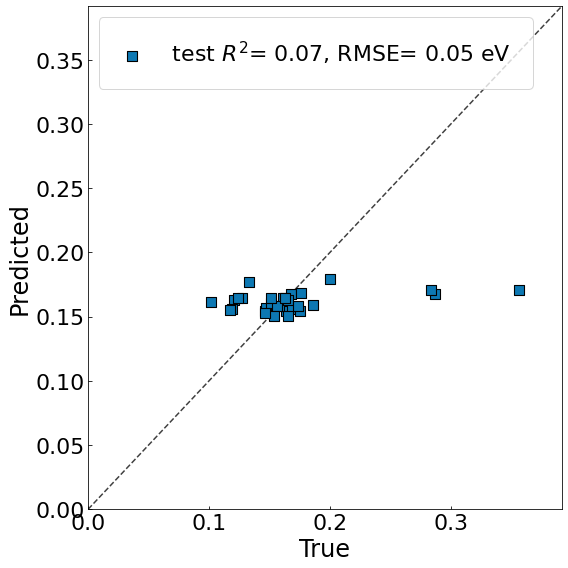

In [568]:
pp.plot(eval_set[1].to_numpy().flatten().tolist(),preds.flatten().tolist(),save=False)